作業2：使用 Transformer 模型預測股價漲跌，自訂窗口大小，並分析預測結果。
 
輸出結果範例：
輸入20天收盤價，預測隔一天收盤價

In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, GlobalAveragePooling1D,MultiHeadAttention, LayerNormalization
import yfinance as yf

class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential(
            [Dense(ff_dim, activation="relu"), Dense(embed_dim),]
        )
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)


code = "1301.TW"

data = yf.download(code, start="2024-01-01", end="2024-10-30")
data.columns = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']

[*********************100%***********************]  1 of 1 completed


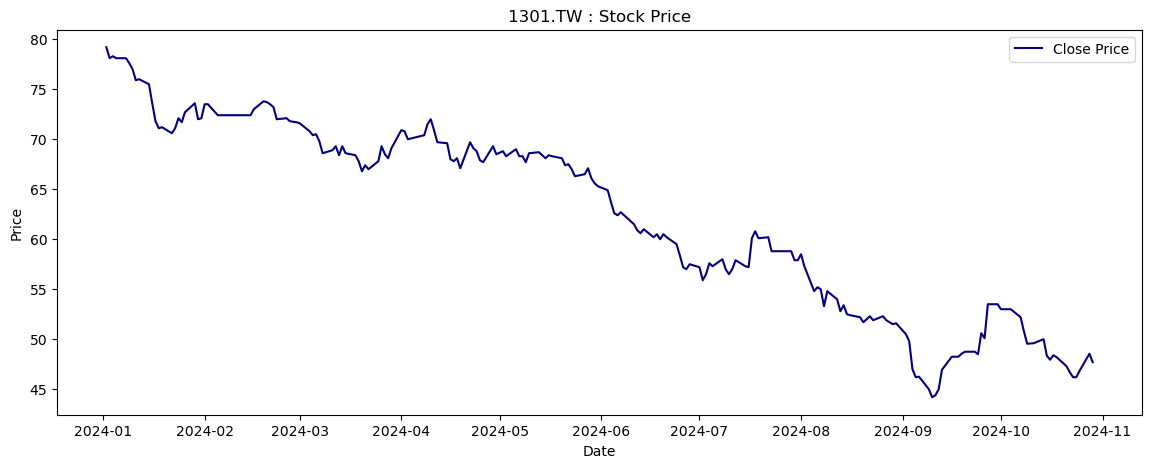

In [60]:
# 查看data視覺化
plt.figure(figsize=(14, 5))
plt.plot(data['Close'], label='Close Price',color="navy")
plt.ylabel('Price')
plt.xlabel('Date')
plt.title(f'{code} : Stock Price')
plt.legend()
plt.show()

In [61]:
close_data = data['Close'].values
scaler = MinMaxScaler(feature_range=(0, 1))
close_data_scaled = scaler.fit_transform(close_data.reshape(-1, 1))

In [62]:
def create_dataset(dataset, time_step=20):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step)]
        dataX.append(a)
        dataY.append(dataset[i + time_step])
    return np.array(dataX), np.array(dataY)

window_size = 20
X, y = create_dataset(close_data_scaled, window_size)
